In [1]:
import nltk
import numpy as np
import pandas as pd

#Language Processing
from nltk.tokenize import TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import emoji
from emoji import emojize
import string
import re


#Vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#SKLrean models
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# set plot style
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#Wordcloud
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

In [3]:
new_df=df_train

In [4]:
sentiment_counts = df_train.sentiment.value_counts()
number_of_tweets = df_train.tweetid.count()
print(sentiment_counts)

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


In [5]:
# look at data statistics
df_train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [6]:
df_test.describe()

,tweetid
count,10546.000000
mean,496899.936943
std,288115.677148
min,231.000000
25%,246162.500000
50%,495923.000000
75%,742250.000000
max,999983.000000


In [7]:
#Check for null values
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [8]:
df_test.isnull().sum()

message    0
tweetid    0
dtype: int64

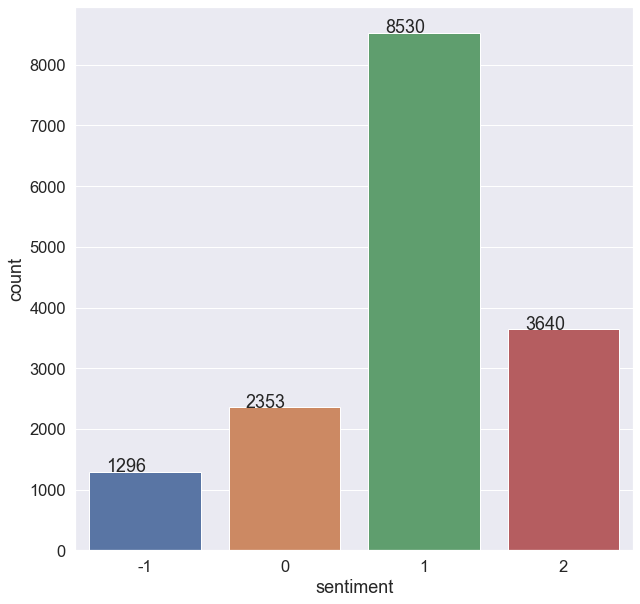

In [9]:
sns.set(font_scale=1.5)
fig, ax1 = plt.subplots(figsize=(10,10))
graph = sns.countplot(ax=ax1,x='sentiment', data=df_train)
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/3., height + 0.1,height ,ha="center")

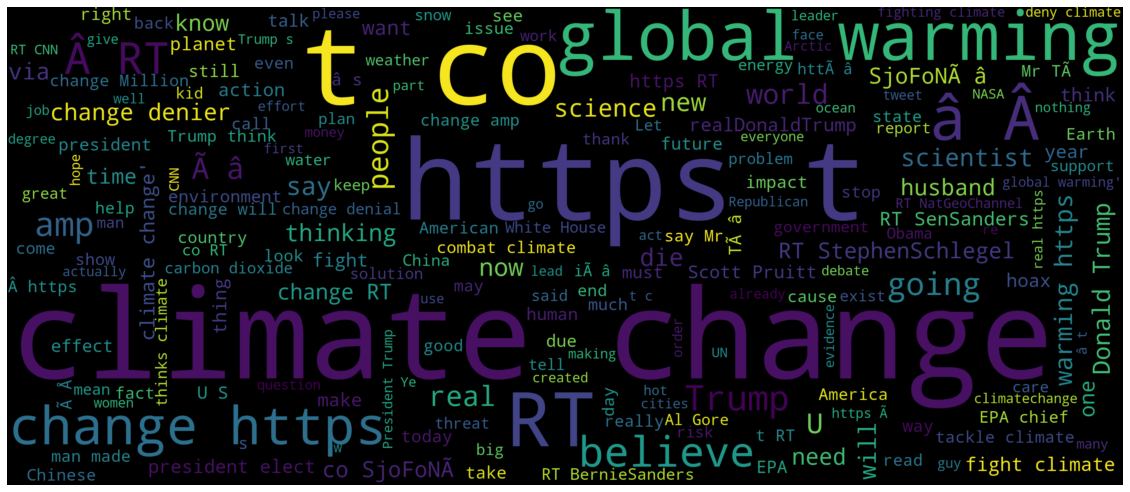

In [10]:
#Frequent words before cleaning the train set
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
words_train=" ".join([tweet for tweet in df_train['message']])
wordcloud = WordCloud(background_color='black',width=2800, height=1200,random_state=26).generate(words_train)
# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# EDA

In [11]:
df_copy = df_train.copy()
# Labeling the target
df_copy ['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in df_copy['sentiment']]

In [12]:
df_copy.head()

,sentiment,message,tweetid
0,Positive,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Positive,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Positive,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Positive,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


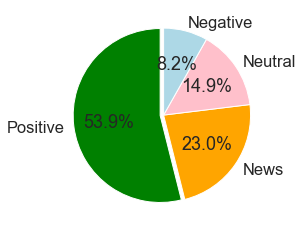

In [13]:
# checking the numerical distribution
values = df_copy['sentiment'].value_counts()/df_copy.shape[0]
labels = (df_copy['sentiment'].value_counts()/df_copy.shape[0]).index
colors = ['green', 'orange', 'pink', 'lightblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

In [14]:
def feature_count(argu):
    sentiment_df = df_copy[df_copy['message'].str.contains(argu)]
    sentiment_df = (sentiment_df.groupby('sentiment').count()/df.groupby('sentiment').count())*100
    sentiment_df['percentage'] = sentiment_df['message']
    sentiment_df = sentiment_df[['percentage']]
    
    return sentiment_df

grouped = df_copy.groupby(df_copy.sentiment)
deny_df = grouped.get_group('Negative')
pro_df = grouped.get_group('Positive')
media_df = grouped.get_group('News')
neutral_df = grouped.get_group('Neutral')

import itertools
import collections
# Create a list of lists containing lowercase words for each tweet
words_in_all_tweet = [tweet.split() for tweet in df_copy['message']]
deny_tweets_list = [deny_tweet.split() for deny_tweet in deny_df['message']]
pro_tweets_list = [pro_tweet.split() for pro_tweet in pro_df['message']]
media_tweets_list = [media_tweet.split() for media_tweet in media_df['message']]
neutral_tweets_list = [neutral_tweet.split() for neutral_tweet in neutral_df['message']]


# List of all words across tweets
clean_message_all_list= list(itertools.chain(*words_in_all_tweet))
clean_message_list_deny= list(itertools.chain(*deny_tweets_list))
clean_message_list_pro= list(itertools.chain(*pro_tweets_list))
clean_message_list_meida= list(itertools.chain(*media_tweets_list))
clean_message_list_neutral= list(itertools.chain(*neutral_tweets_list))

# Create counter
counts_clean_message_all = collections.Counter(clean_message_all_list)
counts_clean_message_deny = collections.Counter(clean_message_list_deny)
counts_clean_message_pro = collections.Counter(clean_message_list_pro)
counts_clean_message_media= collections.Counter(clean_message_list_meida)
counts_clean_message_neutral = collections.Counter(clean_message_list_neutral)

common_words_number = 15
counts_clean_message_all.most_common(common_words_number)
counts_clean_message_deny.most_common(common_words_number)
counts_clean_message_pro.most_common(common_words_number)
counts_clean_message_media.most_common(common_words_number)
counts_clean_message_neutral.most_common(common_words_number)

#Build a Dataframe of the words in the tweets as well as their count
tweet_word_counts_all = pd.DataFrame(counts_clean_message_all.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_deny = pd.DataFrame(counts_clean_message_deny.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_pro = pd.DataFrame(counts_clean_message_pro.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_media = pd.DataFrame(counts_clean_message_media.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_neutral = pd.DataFrame(counts_clean_message_neutral.most_common(common_words_number),
                             columns=['words', 'count'])

Text(0.5, 1.0, 'Common Words Found in neutral tweets')

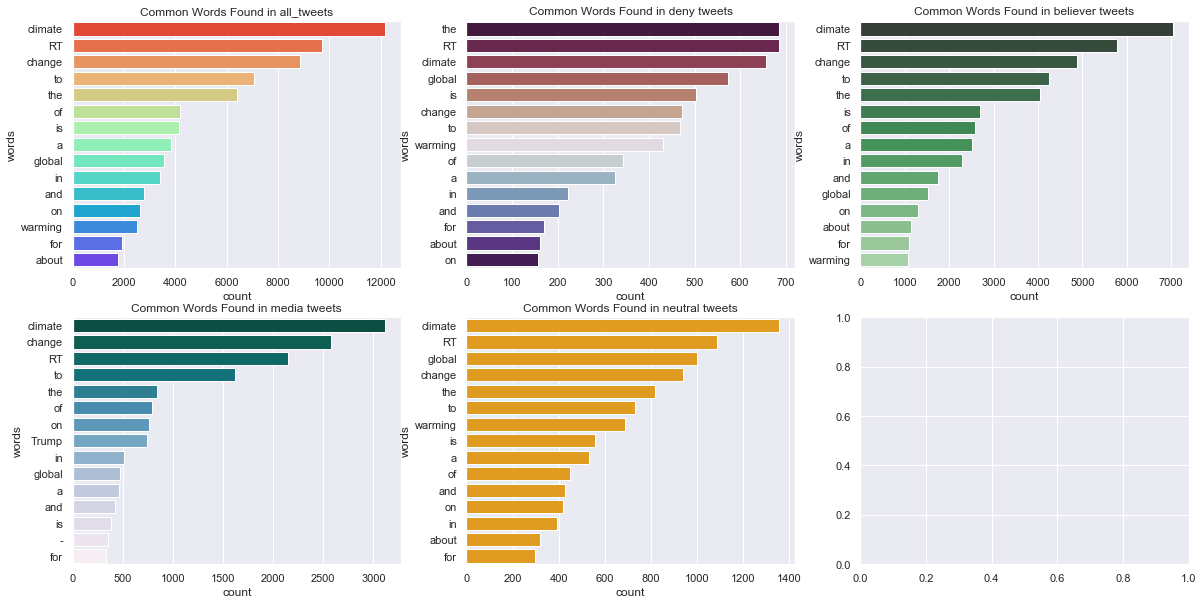

In [15]:
sns.set(font_scale=1)
fig, axes = plt.subplots(2,3, figsize=(20, 10), squeeze=False)

sns.barplot(y='words' ,x=tweet_word_counts_all['count'], data = tweet_word_counts_all.sort_values(by='count', ascending=False),ax=axes[0,0], palette = "rainbow_r", orient = 'h')
axes[0,0].set_title("Common Words Found in all_tweets")

sns.barplot(y='words' ,x=tweet_word_counts_deny['count'], data = tweet_word_counts_deny.sort_values(by='count', ascending=False),ax=axes[0,1], palette = "twilight_shifted_r", orient = 'h')
axes[0,1].set_title("Common Words Found in deny tweets")

sns.barplot(y='words' ,x=tweet_word_counts_pro['count'], data = tweet_word_counts_pro.sort_values(by='count', ascending=False),ax=axes[0,2], palette = "Greens_d", orient = 'h')
axes[0,2].set_title("Common Words Found in believer tweets")

sns.barplot(y='words' ,x=tweet_word_counts_media['count'], data = tweet_word_counts_media.sort_values(by='count', ascending=False),ax=axes[1,0], palette = "PuBuGn_r", orient = 'h')
axes[1,0].set_title("Common Words Found in media tweets")

sns.barplot(y='words' ,x=tweet_word_counts_neutral['count'], data = tweet_word_counts_neutral.sort_values(by='count', ascending=False),ax=axes[1,1], color = 'orange', orient = 'h')
axes[1,1].set_title("Common Words Found in neutral tweets")

# **Data Cleaning process**

In [16]:
def remove_pattern(input_text, patterns):
    helper = re.findall(patterns, input_text)
    for i in helper:
        input_text = re.sub(i, '', input_text)
    return input_text

 #Remove Twitter handles from the train and test data 
#df_train['clean_tweet'] = np.vectorize(remove_pattern)(df_train['clean_tweet'], "@[\w]*")
#df_test['clean_tweet'] = np.vectorize(remove_pattern)(df_test['clean_tweet'], "@[\w]*")

In [17]:
# Cleaning links
df_train["clean_tweet"] = df_train['message'].str.replace(r'https://\S+', "")
df_test["clean_tweet"] = df_test['message'].str.replace(r'https://\S+', "")

In [18]:
#pd.set_option('display.max_colwidth', -1)
#df_train.head()

In [19]:
# Remove punctuations, numbers, and special characters
df_train['clean_tweet'] = df_train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df_test['clean_tweet'] = df_test['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

In [20]:
# Remove all words below 2 characters
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


In [21]:
pd.set_option('display.max_colwidth', -1)
df_train.head()

,sentiment,message,tweetid,clean_tweet
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,PolySciMajor EPA chief doesn think carbon dioxide main cause global warming and wait what via mashable
1,1,It's not like we lack evidence of anthropogenic global warming,126103,not like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,RawStory Researchers say have three years act climate change before too late
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#TodayinMaker# WIRED was pivotal year the war climate change
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,SoyNovioDeTodas and racist sexist climate change denying bigot leading the polls #ElectionNight


In [22]:
#More cleaning
wordnet_lemmatizer = WordNetLemmatizer()
def cleandata(message):

    #translate emojis if we have
    message = emoji.demojize(message, delimiters=("", "")) 

    #lowercase
    message = message.lower() 
    
    #removing stopwords
    message = message.split(' ')
    message = ' '.join([word for word in message if word not in stop_words])
    
    #lemmatisation and tokenization
    lemmatizer = WordNetLemmatizer()
    message = [lemmatizer.lemmatize(token) for token in message.split(' ')]
    message = [lemmatizer.lemmatize(token, 'v') for token in message]
    message = ' '.join(message)

    return message

In [23]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df_train['clean_tweet'] = df_train.clean_tweet.apply(cleandata)
df_test['clean_tweet'] = df_test.clean_tweet.apply(cleandata)
df_train.head()

,sentiment,message,tweetid,clean_tweet
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief think carbon dioxide main cause global warm wait via mashable
1,1,It's not like we lack evidence of anthropogenic global warming,126103,like lack evidence anthropogenic global warm
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rawstory researcher say three year act climate change late
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#todayinmaker# wire pivotal year war climate change
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,soynoviodetodas racist sexist climate change deny bigot lead poll #electionnight


In [24]:
df_test.head()

,message,tweetid,clean_tweet
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760,europe look china make sure alone fight climate change
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326,combine poll staffer climate change woman right fascist state
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985,scary unimpeachable evidence climate change already #itstimetochange #climatechange zeroco
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263,karoli morgfair osborneink dailykos putin get jill trump believe climate change think hoax
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928,fakewillmoore female orgasm cause global warm sarcastic republican


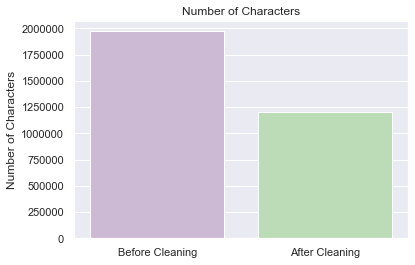

In [25]:
# Combining all the messages
text_before_cleaning = " ".join(tweet for tweet in df_train['message'])
text_after_cleaning = " ".join(tweet for tweet in df_train['clean_tweet'])

# Numbers of characters before and after cleaning for both 
sns.barplot(x=['Before Cleaning', 'After Cleaning'], y=[len(text_before_cleaning), len(text_after_cleaning)], palette='PRGn')
# sns.countplot(x=[] ,data = working_df, palette='PRGn')
plt.ylabel('Number of Characters')
# plt.xlabel('Sentiment')
plt.title('Number of Characters')
plt.show()

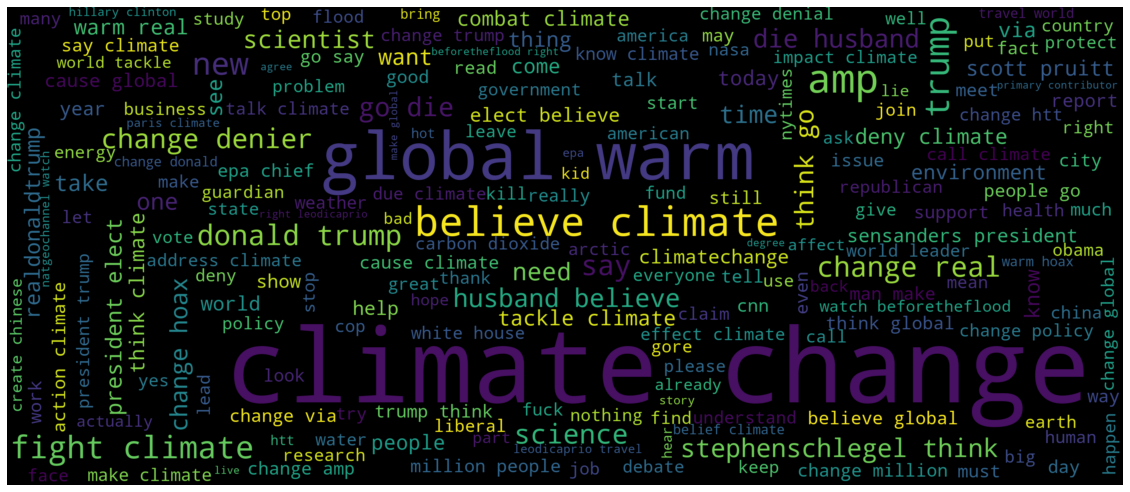

In [26]:
#Most frequent words in the train set
from wordcloud import WordCloud
#Removing most common words in all sentiments from word clouds to see the different words used
stop_words.extend(['climate', 'change', 'global','warm', 'warming', 'url', 'web', 'ÂÂ', 'Â', 'Â Â', 'rt', 'â', 'ââ' ,'â â'])

words_train=" ".join([tweet for tweet in df_train['clean_tweet']])
wordcloud = WordCloud(background_color='black',width=2800, height=1200,random_state=26).generate(words_train)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


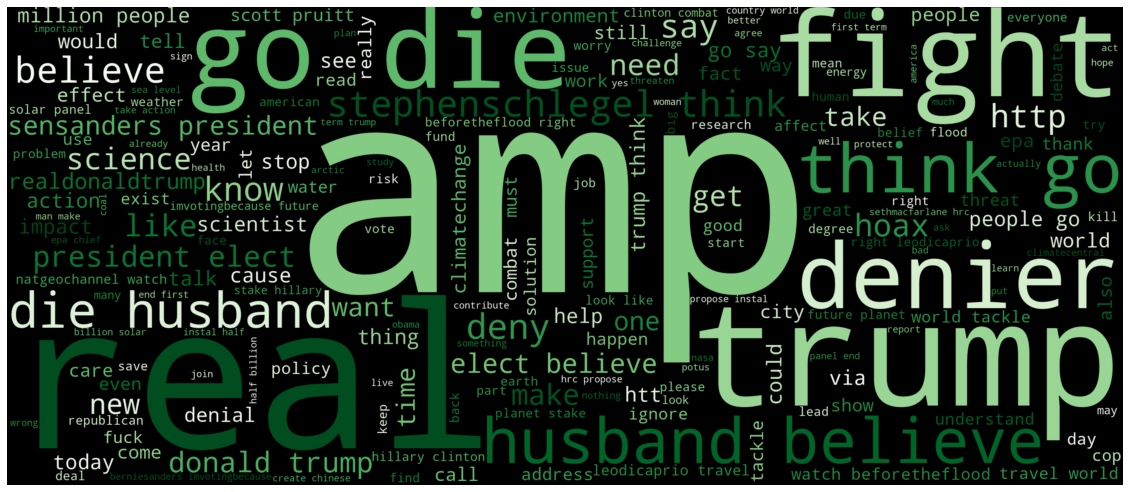

In [27]:
#Most positive frequent words 
positive=" ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==1]])
wordcloud = WordCloud(stopwords=stop_words,colormap="Greens_r",background_color='black',width=2800, height=1200,random_state=42).generate(positive)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

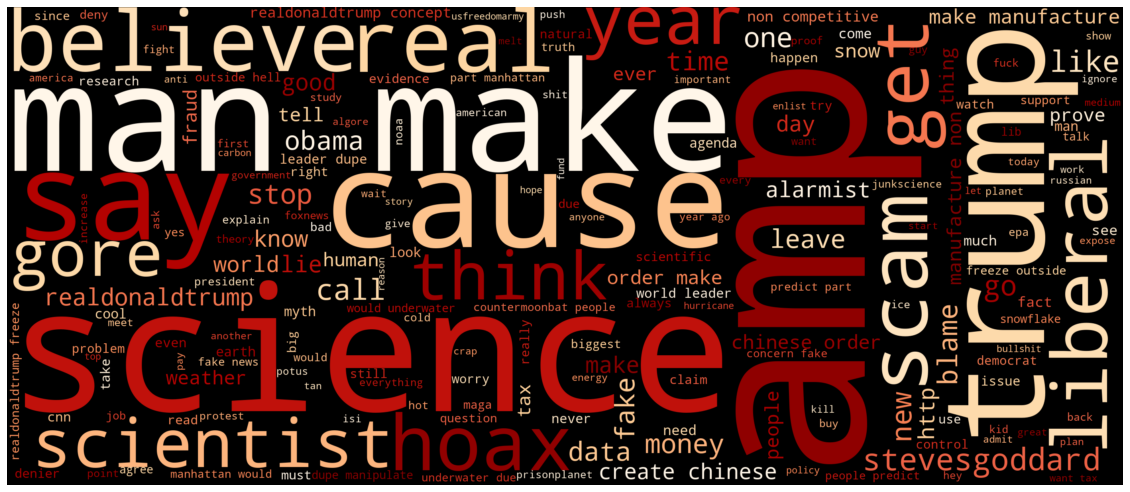

In [28]:
#Most negative frequent words 
negative=" ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==-1]])
wordcloud = WordCloud(stopwords=stop_words,colormap="OrRd_r",background_color='black',width=2800, height=1200,random_state=26).generate(negative)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

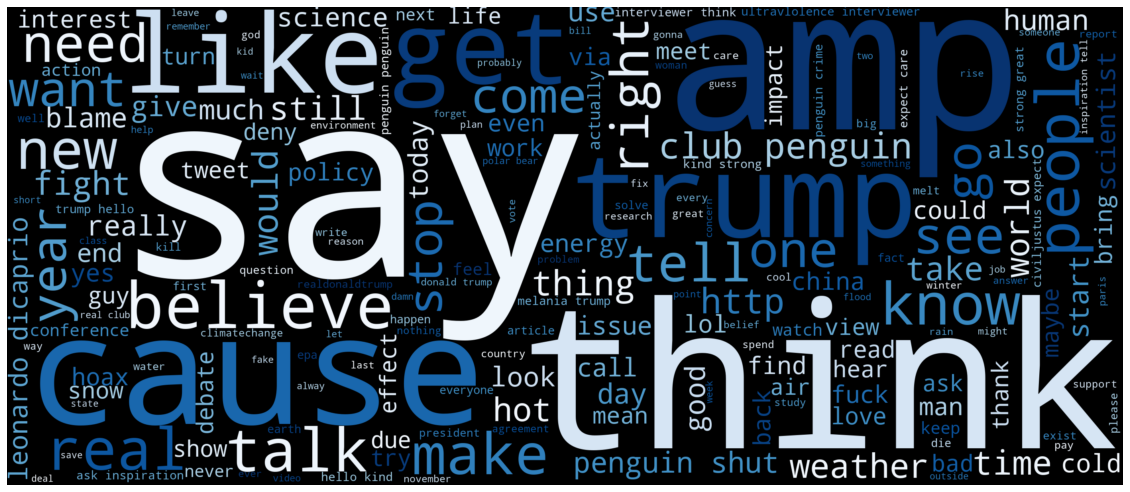

In [29]:
#Most neutral frequent words 
neutral=" ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==0]])
wordcloud = WordCloud(stopwords=stop_words,colormap="Blues",background_color='black',width=2800, height=1200,random_state=26).generate(neutral)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

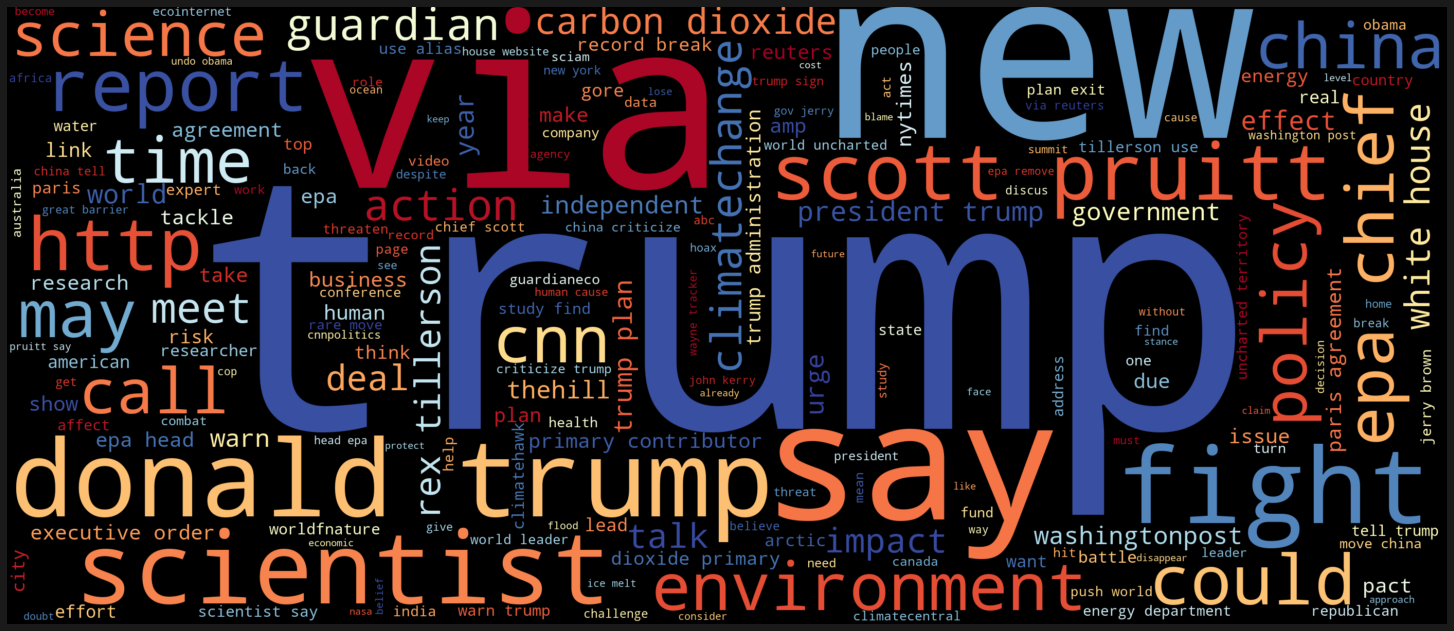

In [30]:
#Most news frequent words 
new=" ".join([tweet for tweet in df_train['clean_tweet'][df_train['sentiment']==2]])
wordcloud = WordCloud(stopwords=stop_words,colormap="RdYlBu_r",background_color='black',width=2800, height=1200,random_state=26).generate(new)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [31]:
df_copy1 = df_train.copy()
# Labeling the target
df_copy1['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in df_copy1['sentiment']]

In [32]:
df_copy1.head()

,sentiment,message,tweetid,clean_tweet
0,Positive,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief think carbon dioxide main cause global warm wait via mashable
1,Positive,It's not like we lack evidence of anthropogenic global warming,126103,like lack evidence anthropogenic global warm
2,News,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rawstory researcher say three year act climate change late
3,Positive,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#todayinmaker# wire pivotal year war climate change
4,Positive,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,soynoviodetodas racist sexist climate change deny bigot lead poll #electionnight


In [33]:
def feature_count(argu2):
    sentiment_df1 = df_copy1[df_copy1['clean_tweet'].str.contains(argu2)]
    sentiment_df1 = (sentiment_df1.groupby('sentiment').count()/df.groupby('sentiment').count())*100
    sentiment_df1['percentage'] = sentiment_df1['clean_tweet']
    sentiment_df1 = sentiment_df1[['percentage']]
    
    return sentiment_df1
grouped1 = df_copy1.groupby(df_copy1.sentiment)
deny_df1 =grouped1.get_group('Negative')
pro_df1 = grouped1.get_group('Positive')
media_df1 = grouped1.get_group('News')
neutral_df1 = grouped1.get_group('Neutral')

import itertools
import collections
# Create a list of lists containing lowercase words for each tweet
words_in_all_tweet1 = [tweet.split() for tweet in df_copy1['clean_tweet']]
deny_tweets_list1 = [deny_tweet.split() for deny_tweet in deny_df1['clean_tweet']]
pro_tweets_list1 = [pro_tweet.split() for pro_tweet in pro_df1['clean_tweet']]
media_tweets_list1 = [media_tweet.split() for media_tweet in media_df1['clean_tweet']]
neutral_tweets_list1 = [neutral_tweet.split() for neutral_tweet in neutral_df1['clean_tweet']]


# List of all words across tweets
clean_message_all_list1= list(itertools.chain(*words_in_all_tweet1))
clean_message_list_deny1= list(itertools.chain(*deny_tweets_list1))
clean_message_list_pro1= list(itertools.chain(*pro_tweets_list1))
clean_message_list_meida1= list(itertools.chain(*media_tweets_list1))
clean_message_list_neutral1= list(itertools.chain(*neutral_tweets_list1))

# Create counter
counts_clean_message_all1 = collections.Counter(clean_message_all_list1)
counts_clean_message_deny1 = collections.Counter(clean_message_list_deny1)
counts_clean_message_pro1 = collections.Counter(clean_message_list_pro1)
counts_clean_message_media1= collections.Counter(clean_message_list_meida1)
counts_clean_message_neutral1 = collections.Counter(clean_message_list_neutral1)

common_words_number = 15
counts_clean_message_all1.most_common(common_words_number)
counts_clean_message_deny1.most_common(common_words_number)
counts_clean_message_pro1.most_common(common_words_number)
counts_clean_message_media1.most_common(common_words_number)
counts_clean_message_neutral1.most_common(common_words_number)

#Build a Dataframe of the words in the tweets as well as their count
tweet_word_counts_all1 = pd.DataFrame(counts_clean_message_all1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_deny1 = pd.DataFrame(counts_clean_message_deny1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_pro1 = pd.DataFrame(counts_clean_message_pro1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_media1 = pd.DataFrame(counts_clean_message_media1.most_common(common_words_number),
                             columns=['words', 'count'])
tweet_word_counts_neutral1 = pd.DataFrame(counts_clean_message_neutral1.most_common(common_words_number),
                             columns=['words', 'count'])

Text(0.5, 1.0, 'Common Words Found in neutral tweets after data cleaning')

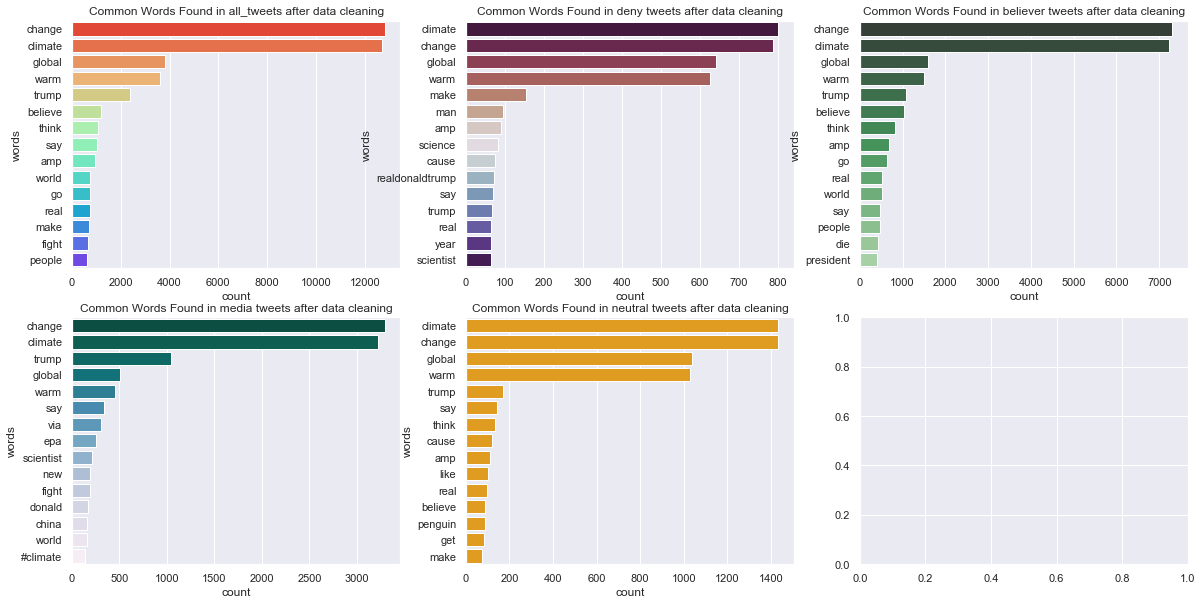

In [34]:
sns.set(font_scale=1)
fig, axes = plt.subplots(2,3, figsize=(20, 10), squeeze=False)

sns.barplot(y='words' ,x=tweet_word_counts_all1['count'], data = tweet_word_counts_all1.sort_values(by='count', ascending=False),ax=axes[0,0], palette = "rainbow_r", orient = 'h')
axes[0,0].set_title("Common Words Found in all_tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_deny1['count'], data = tweet_word_counts_deny1.sort_values(by='count', ascending=False),ax=axes[0,1], palette = "twilight_shifted_r", orient = 'h')
axes[0,1].set_title("Common Words Found in deny tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_pro1['count'], data = tweet_word_counts_pro1.sort_values(by='count', ascending=False),ax=axes[0,2], palette = "Greens_d", orient = 'h')
axes[0,2].set_title("Common Words Found in believer tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_media1['count'], data = tweet_word_counts_media1.sort_values(by='count', ascending=False),ax=axes[1,0], palette = "PuBuGn_r", orient = 'h')
axes[1,0].set_title("Common Words Found in media tweets after data cleaning")

sns.barplot(y='words' ,x=tweet_word_counts_neutral1['count'], data = tweet_word_counts_neutral1.sort_values(by='count', ascending=False),ax=axes[1,1], color = 'orange', orient = 'h')
axes[1,1].set_title("Common Words Found in neutral tweets after data cleaning")

# Split data 

In [35]:

X = df_train['clean_tweet']
y = df_train['sentiment']

X_real = df_test['clean_tweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=32,  shuffle = True, stratify=y)


# Modelling

In [36]:

#Using a pipeline to train the model
#LinearSVC
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', LinearSVC())])
pipe.fit(X_train, y_train)
y_pred_lsvc = pipe.predict(X_test)
print('model: Linear SVC Metrics')
print(metrics.classification_report(y_test, y_pred_lsvc))
print("F1 Score:",f1_score(y_test, y_pred_lsvc,average='weighted'))
#-----------------------------------------------------------------------------------
#LogisticRegression
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', LogisticRegression())])
pipe.fit(X_train, y_train)
y_pred_lr = pipe.predict(X_test)
print('model: LogisticRegression Metrics')
print(metrics.classification_report(y_test, y_pred_lr))
print("F1 Score:",f1_score(y_test, y_pred_lsvc,average='weighted'))
#-----------------------------------------------------------------------------------
#KNeighborsClassifier
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', KNeighborsClassifier())])
pipe.fit(X_train, y_train)
y_pred_kn = pipe.predict(X_test)
print('model: LKNeighbours Metrics')
print(metrics.classification_report(y_test, y_pred_kn))
print("F1 Score:",f1_score(y_test,y_pred_kn,average='weighted'))
#-----------------------------------------------------------------------------------
#SVC-linearKernel
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', SVC(kernel='linear'))])
pipe.fit(X_train, y_train)
y_pred_lksvc = pipe.predict(X_test)
print('model: SVC linearKernel Metrics')
print(metrics.classification_report(y_test, y_pred_lksvc))
print("F1 Score:",f1_score(y_test, y_pred_lksvc,average='weighted'))
#SVC-RadialKernel
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', SVC(kernel='rbf'))])
pipe.fit(X_train, y_train)
y_pred_rksvc = pipe.predict(X_test)
print('model: SVC RadialKernel Metrics')
print(metrics.classification_report(y_test, y_pred_rksvc))
print("F1 Score:",f1_score(y_test, y_pred_rksvc,average='weighted'))
#------------------------------------------------------------------------------------
# GradientBoostingClassifier
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', GradientBoostingClassifier())])
pipe.fit(X_train, y_train)
y_pred_gb = pipe.predict(X_test)
print('model: GradientBoost Metrics')
print(metrics.classification_report(y_test, y_pred_gb))
print("F1 Score:",f1_score(y_test, y_pred_gb,average='weighted'))
#-----------------------------------------------------------------------------------
#AdaBoostClassifier
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', AdaBoostClassifier())])
pipe.fit(X_train, y_train)
y_pred_ab = pipe.predict(X_test)
print('model: AdaBoost Metrics')
print(metrics.classification_report(y_test, y_pred_ab))
print("F1 Score:",f1_score(y_test, y_pred_ab,average='weighted'))
#-----------------------------------------------------------------------------------
# DecisionTreeClassifier
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)
y_pred_dt = pipe.predict(X_test)
print('model: DecisionTree Metrics')
print(metrics.classification_report(y_test, y_pred_dt))
print("F1 Score:",f1_score(y_test, y_pred_dt,average='weighted'))
#-----------------------------------------------------------------------------------
#RandomForest
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', RandomForestClassifier())])
pipe.fit(X_train, y_train)
y_pred_rf = pipe.predict(X_test)
print('model: RandomForest Metrics')
print(metrics.classification_report(y_test, y_pred_rf))
print("F1 Score:",f1_score(y_test, y_pred_rf,average='weighted'))
#---------------------------------------------------------------------------------------
#MultinomialNB
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', min_df=1, max_df=0.9, ngram_range=(1, 2))),
                ('classification', MultinomialNB())])
pipe.fit(X_train, y_train)
y_pred_mnb = pipe.predict(X_test)
print('model: MNB Metrics')
print(metrics.classification_report(y_test, y_pred_mnb))
print("F1 Score:",f1_score(y_test, y_pred_mnb,average='weighted'))

model: Linear SVC Metrics
              precision    recall  f1-score   support

          -1       0.76      0.60      0.67        65
           0       0.69      0.42      0.52       118
           1       0.75      0.85      0.80       426
           2       0.72      0.74      0.73       182

    accuracy                           0.74       791
   macro avg       0.73      0.65      0.68       791
weighted avg       0.74      0.74      0.73       791

F1 Score: 0.7315741444323497
model: LogisticRegression Metrics
              precision    recall  f1-score   support

          -1       0.88      0.45      0.59        65
           0       0.61      0.35      0.44       118
           1       0.71      0.88      0.79       426
           2       0.75      0.67      0.71       182

    accuracy                           0.72       791
   macro avg       0.74      0.59      0.63       791
weighted avg       0.72      0.72      0.70       791

F1 Score: 0.7315741444323497
model: LKNei

In [37]:
# StackingClassifier
level0 = list()
level0.append(('mnb', MultinomialNB()))
level0.append(('mnb0.001', MultinomialNB(alpha = 0.001)))
level0.append(('lr', LogisticRegression(n_jobs=-1)))
level0.append(('lr2', LogisticRegression(C = 100, max_iter=5000, n_jobs=-1)))
level0.append(('svc', SVC(kernel='linear')))
#Model1(definening meta model and define stacking ensemble)
level1 = LinearSVC()
model = StackingClassifier(estimators=level0, final_estimator=level1)
pipe = Pipeline([ ('tfidf', TfidfVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')),
                 ('clf', model)
                ], verbose = 10)
pipe.fit(X_train, y_train)

#Predict and evaluate
y_pred_lsvc = pipe.predict(X_test)

print('model: Linear SVC Metrics')
print(metrics.classification_report(y_test, y_pred_lsvc))
print("F1 Score:",f1_score(y_test, y_pred_lsvc,average='weighted'))

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.1min
model: Linear SVC Metrics
              precision    recall  f1-score   support

          -1       0.77      0.66      0.71        65
           0       0.70      0.41      0.51       118
           1       0.75      0.86      0.80       426
           2       0.76      0.74      0.75       182

    accuracy                           0.75       791
   macro avg       0.74      0.67      0.69       791
weighted avg       0.75      0.75      0.74       791

F1 Score: 0.7400597441170658


In [38]:
#testing model
y_pred_lr_real = pipe.predict(X_real)

df_test['sentiment'] = y_pred_lr_real

In [39]:
df_test[['tweetid','sentiment']].to_csv('Team_8.csv', index=False)

In [40]:
df_test.head(50)

,message,tweetid,clean_tweet,sentiment
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760,europe look china make sure alone fight climate change,1
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326,combine poll staffer climate change woman right fascist state,1
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985,scary unimpeachable evidence climate change already #itstimetochange #climatechange zeroco,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263,karoli morgfair osborneink dailykos putin get jill trump believe climate change think hoax,1
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928,fakewillmoore female orgasm cause global warm sarcastic republican,0
5,RT @nycjim: Trump muzzles employees of several gov’t agencies in effort to suppress info on #climate change &amp; the environment. https://t.co…,75639,nycjim trump muzzle employee several gov agency effort suppress info #climate change amp environment,1
6,@bmastenbrook yes wrote that in 3rd yr Comp Sci ethics part. Was told by climate change denying Lecturer that I was wrong &amp; marked down.,211536,bmastenbrook yes write comp sci ethic part tell climate change deny lecturer wrong amp mark,1
7,RT @climatehawk1: Indonesian farmers weather #climate change w/ conservation agriculture | @IPSNews https://t.co/1NZUCCMlYr…,569434,climatehawk indonesian farmer weather #climate change conservation agriculture ipsnews,1
8,RT @guardian: British scientists face a ‘huge hit’ if the US cuts climate change research https://t.co/KlKQnYDXzh,315368,guardian british scientist face huge hit cut climate change research,1
9,Aid For Agriculture | Sustainable agriculture and climate change adaptation for small-scale farmers https://t.co/q7IPCP59x9 via @aid4ag,591733,aid agriculture sustainable agriculture climate change adaptation small scale farmer via aid,1
